## Kaggel: Digit Recognizer(MNIST)  by Hyperopt + fit_generator()
Kaggle Digit recognizer: https://www.kaggle.com/c/digit-recognizer  
Hyperopt: https://github.com/hyperopt/hyperopt  

### Best Score: 0.99685
* max_evals= 10 (time: 1h 5m),  score: 0.99685
* max_evals= 20 (time: --),     score: 0.99657
* max_evals= 30 (time: 5h 26m), score: 0.99671

Python 3.6  
NVIDIA GTX1060  

In [32]:
import warnings
warnings.filterwarnings('ignore')

import hyperopt
from hyperopt import hp, fmin, rand, tpe, Trials, space_eval, STATUS_OK

from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
import keras

import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# fix random seed
import tensorflow as tf
import random as rn
import os
os.environ['PYTHONHASHSEED'] = '0'
seed = 123
rn.seed(seed)
np.random.seed(seed)
session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
from keras import backend as K
tf.set_random_seed(seed)
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)

print('tensorflow ver.:',tf.__version__)
print('keras ver.     : ', keras.__version__)
print('hyperopt ver.  :   ', hyperopt.__version__)

tensorflow ver.: 1.11.0
keras ver.     :  2.2.2
hyperopt ver.  :    0.2


## Data preparation: MNIST from Kaggle
* data split proportion: test_size=0.15

In [33]:
train = pd.read_csv('../train.csv')
label = train.label
train = train.drop(['label'], axis=1)
train = train.values.reshape(-1, 28, 28, 1)

x_train, x_test, y_train, y_test = train_test_split(train, label, test_size=0.15, shuffle=True, random_state=seed)
x_train, x_val, y_train, y_val = train_test_split(train, label, test_size=0.15, shuffle=True, random_state=seed)
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0
x_val = x_val.astype('float32') / 255.0

[x_train.shape, x_val.shape, x_test.shape]

[(35700, 28, 28, 1), (6300, 28, 28, 1), (6300, 28, 28, 1)]

## Hyperparameters for Hyperopt:  
* five Dropout rates

In [34]:
params = {
    'Dropout_0':        hp.uniform('Dropout_0', 0.0, 0.5),
    'Dropout_1':        hp.uniform('Dropout_1', 0.0, 0.5),
    #'Dropout_2':        hp.uniform('Dropout_2', 0.0, 0.5),
    'Dropout_3':        hp.uniform('Dropout_3', 0.0, 0.5)
    #'Dropout_4':        hp.uniform('Dropout_4', 0.0, 0.5)
}

## CNN Model:
* return a dictionary includes at least 'loss' and 'status' for hyperopt
* the model pass -acc(negative accuracy) as a 'loss' value to the fmin()

In [35]:
batch_size = 32

cnt = 0
def cnn_model(params):
    
    initializer = keras.initializers.glorot_uniform(seed=seed)
    
    model = Sequential()  
    model.add(Conv2D(32*2, (5,5), padding='same', activation='relu', kernel_initializer=initializer, input_shape=(28,28,1)))
    model.add(BatchNormalization())
    model.add(Conv2D(32*2, (5,5), padding='same', activation='relu', kernel_initializer=initializer))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size=(2,2)))
    #model.add(BatchNormalization())
    model.add(Dropout(params['Dropout_0'], seed=seed))
    
    model.add(Conv2D(64*2, (3,3), padding='same', activation='relu', kernel_initializer=initializer))
    model.add(BatchNormalization())
    model.add(Conv2D(64*2, (3,3), padding='same', activation='relu', kernel_initializer=initializer))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
    #model.add(BatchNormalization())
    model.add(Dropout(params['Dropout_1'], seed=seed))
    
#     model.add(Conv2D(128, (3,3), padding='same', activation='relu', kernel_initializer=initializer))
#     model.add(BatchNormalization())
#     model.add(Conv2D(128, (3,3), padding='same', activation='relu', kernel_initializer=initializer))
#     model.add(BatchNormalization())
#     model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
#     #model.add(BatchNormalization())
#     model.add(Dropout(params['Dropout_2'], seed=seed))

    model.add(Flatten())
    model.add(Dense(512, activation="relu", kernel_initializer=initializer))
    model.add(BatchNormalization())
    model.add(Dropout(params['Dropout_3'], seed=seed))
#     model.add(Dense(128, activation = "relu", kernel_initializer=initializer))
#     model.add(BatchNormalization())
#     model.add(Dropout(params['Dropout_4'], seed=seed))
    
    model.add(Dense(10, activation = "softmax", kernel_initializer=initializer))

    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    datagen = ImageDataGenerator(rotation_range=10,
                                 width_shift_range=0.1,
                                 height_shift_range=0.1,
                                 zoom_range=0.1)

    datagen.fit(x_train, seed=seed)

    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6, verbose=1)
    early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1)

    hist = model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size), 
                                        epochs=50, 
                                        validation_data=(x_val, y_val),
                                        steps_per_epoch=x_train.shape[0]//batch_size,
                                        callbacks=[reduce_lr, early_stop],
                                        verbose=2)

    loss = hist.history['val_loss'][-1]
    acc = hist.history['val_acc'][-1]

    global cnt
    print(cnt, ': Val loss:', loss, ': Val acc:', acc, '\n\n')
    cnt += 1
    
    return {'loss': -acc, 'status': STATUS_OK, 'model': model, 'hist': hist}
    

## Search the Hyperparameters & the Best model:

In [36]:
trials = Trials()
best = fmin(fn=cnn_model, 
            space=params, 
            algo=tpe.suggest, 
            max_evals=10, # 50: 5h 15m
            trials=trials,
            verbose=1,
            rstate=np.random.RandomState(seed))

best

Epoch 1/50
 - 33s - loss: 0.2318 - acc: 0.9292 - val_loss: 0.0639 - val_acc: 0.9813
Epoch 2/50
 - 25s - loss: 0.0990 - acc: 0.9690 - val_loss: 0.0331 - val_acc: 0.9897
Epoch 3/50
 - 25s - loss: 0.0837 - acc: 0.9743 - val_loss: 0.0459 - val_acc: 0.9852
Epoch 4/50
 - 25s - loss: 0.0676 - acc: 0.9784 - val_loss: 0.0325 - val_acc: 0.9910
Epoch 5/50
 - 25s - loss: 0.0686 - acc: 0.9794 - val_loss: 0.0284 - val_acc: 0.9914
Epoch 6/50
 - 25s - loss: 0.0615 - acc: 0.9812 - val_loss: 0.0377 - val_acc: 0.9890
Epoch 7/50
 - 25s - loss: 0.0493 - acc: 0.9850 - val_loss: 0.0314 - val_acc: 0.9906

Epoch 00007: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 8/50
 - 25s - loss: 0.0343 - acc: 0.9893 - val_loss: 0.0178 - val_acc: 0.9935
Epoch 9/50
 - 25s - loss: 0.0322 - acc: 0.9902 - val_loss: 0.0160 - val_acc: 0.9949
Epoch 10/50
 - 25s - loss: 0.0305 - acc: 0.9899 - val_loss: 0.0188 - val_acc: 0.9949
Epoch 11/50
 - 25s - loss: 0.0314 - acc: 0.9902 - val_loss: 0.0156 - val_acc: 

Epoch 14/50
 - 25s - loss: 0.0191 - acc: 0.9944 - val_loss: 0.0149 - val_acc: 0.9954
Epoch 15/50
 - 25s - loss: 0.0183 - acc: 0.9946 - val_loss: 0.0132 - val_acc: 0.9957

Epoch 00015: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.
Epoch 16/50
 - 25s - loss: 0.0149 - acc: 0.9953 - val_loss: 0.0127 - val_acc: 0.9963
Epoch 17/50
 - 25s - loss: 0.0145 - acc: 0.9955 - val_loss: 0.0127 - val_acc: 0.9967
Epoch 18/50
 - 25s - loss: 0.0125 - acc: 0.9960 - val_loss: 0.0137 - val_acc: 0.9960

Epoch 00018: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.
Epoch 19/50
 - 25s - loss: 0.0129 - acc: 0.9959 - val_loss: 0.0128 - val_acc: 0.9967
Epoch 20/50
 - 25s - loss: 0.0115 - acc: 0.9970 - val_loss: 0.0135 - val_acc: 0.9960

Epoch 00020: ReduceLROnPlateau reducing learning rate to 1.5625000742147677e-05.
Epoch 21/50
 - 25s - loss: 0.0119 - acc: 0.9962 - val_loss: 0.0134 - val_acc: 0.9962
Epoch 22/50
 - 25s - loss: 0.0115 - acc: 0.9967 - val_loss: 0.0129 - val_acc:

Epoch 22/50
 - 26s - loss: 0.0122 - acc: 0.9960 - val_loss: 0.0132 - val_acc: 0.9960

Epoch 00022: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.
Epoch 23/50
 - 26s - loss: 0.0101 - acc: 0.9967 - val_loss: 0.0121 - val_acc: 0.9957
Epoch 24/50
 - 26s - loss: 0.0112 - acc: 0.9962 - val_loss: 0.0119 - val_acc: 0.9963

Epoch 00024: ReduceLROnPlateau reducing learning rate to 1.5625000742147677e-05.
Epoch 25/50
 - 26s - loss: 0.0122 - acc: 0.9964 - val_loss: 0.0134 - val_acc: 0.9962
Epoch 00025: early stopping
6 : Val loss: 0.013434822515493059 : Val acc: 0.9961904761904762 


Epoch 1/50
 - 34s - loss: 0.2775 - acc: 0.9128 - val_loss: 0.0951 - val_acc: 0.9705
Epoch 2/50
 - 26s - loss: 0.1142 - acc: 0.9634 - val_loss: 0.0757 - val_acc: 0.9775
Epoch 3/50
 - 26s - loss: 0.0906 - acc: 0.9716 - val_loss: 0.0385 - val_acc: 0.9876
Epoch 4/50
 - 26s - loss: 0.0862 - acc: 0.9723 - val_loss: 0.0374 - val_acc: 0.9876
Epoch 5/50
 - 25s - loss: 0.0751 - acc: 0.9774 - val_loss: 0.0272

 - 26s - loss: 0.0142 - acc: 0.9957 - val_loss: 0.0094 - val_acc: 0.9973

Epoch 00026: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.
Epoch 27/50
 - 26s - loss: 0.0135 - acc: 0.9958 - val_loss: 0.0102 - val_acc: 0.9965
Epoch 28/50
 - 26s - loss: 0.0139 - acc: 0.9956 - val_loss: 0.0102 - val_acc: 0.9973

Epoch 00028: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.
Epoch 29/50
 - 26s - loss: 0.0125 - acc: 0.9959 - val_loss: 0.0101 - val_acc: 0.9971
Epoch 00029: early stopping
9 : Val loss: 0.010069814469989358 : Val acc: 0.9971428571428571 




{'Dropout_0': 0.46931691915532725,
 'Dropout_1': 0.31121430781942666,
 'Dropout_3': 0.36368165904660016}

## Best Hyperparameters:

In [37]:
space_eval(params, best)

{'Dropout_0': 0.46931691915532725,
 'Dropout_1': 0.31121430781942666,
 'Dropout_3': 0.36368165904660016}

## Best Result

In [38]:
trials.best_trial['result']

{'hist': <keras.callbacks.History at 0x7f486b633d68>,
 'loss': -0.9971428571428571,
 'model': <keras.engine.sequential.Sequential at 0x7f487d65c208>,
 'status': 'ok'}

## Best model:

In [39]:
best_model = trials.best_trial['result']['model']
#best_model.save('hyperopt_mnist_best_model.hdf5')

## Evaluation on Test data:

In [40]:
score = best_model.evaluate(x_test, y_test, verbose=1)
score

6300/6300 [==============================] - 2s 319us/step


[0.010069814469989358, 0.9971428571428571]

## Prediction for the Submission:

In [41]:
test = pd.read_csv('../test.csv')
test_index = test.index
test = test.values.reshape(-1, 28, 28, 1).astype('float32') / 255.0

pred = best_model.predict(test, verbose=1)
result = pred.argmax(axis=1)

28000/28000 [==============================] - 12s 439us/step


## Output the Submission csv file:

In [42]:
submission = pd.DataFrame({'ImageId': test_index+1, 'Label': result})
submission.to_csv('hyperopt_gen.csv', index=False)

#### Comparison with the previous result scored at 0.99685

In [43]:
prev_result = pd.read_csv('hyperopt_gen_99685.csv', index_col=0)
curr_result = pd.read_csv('hyperopt_gen.csv', index_col=0)
match_num = np.sum(prev_result.Label.values == curr_result.Label.values)
comp_acc = match_num / len(curr_result)
print('Approx. accuracy: {0:.5f}'.format(comp_acc))

Approx. accuracy: 0.99664


Difference: 94
Image Title: [previous result, current result, id number]


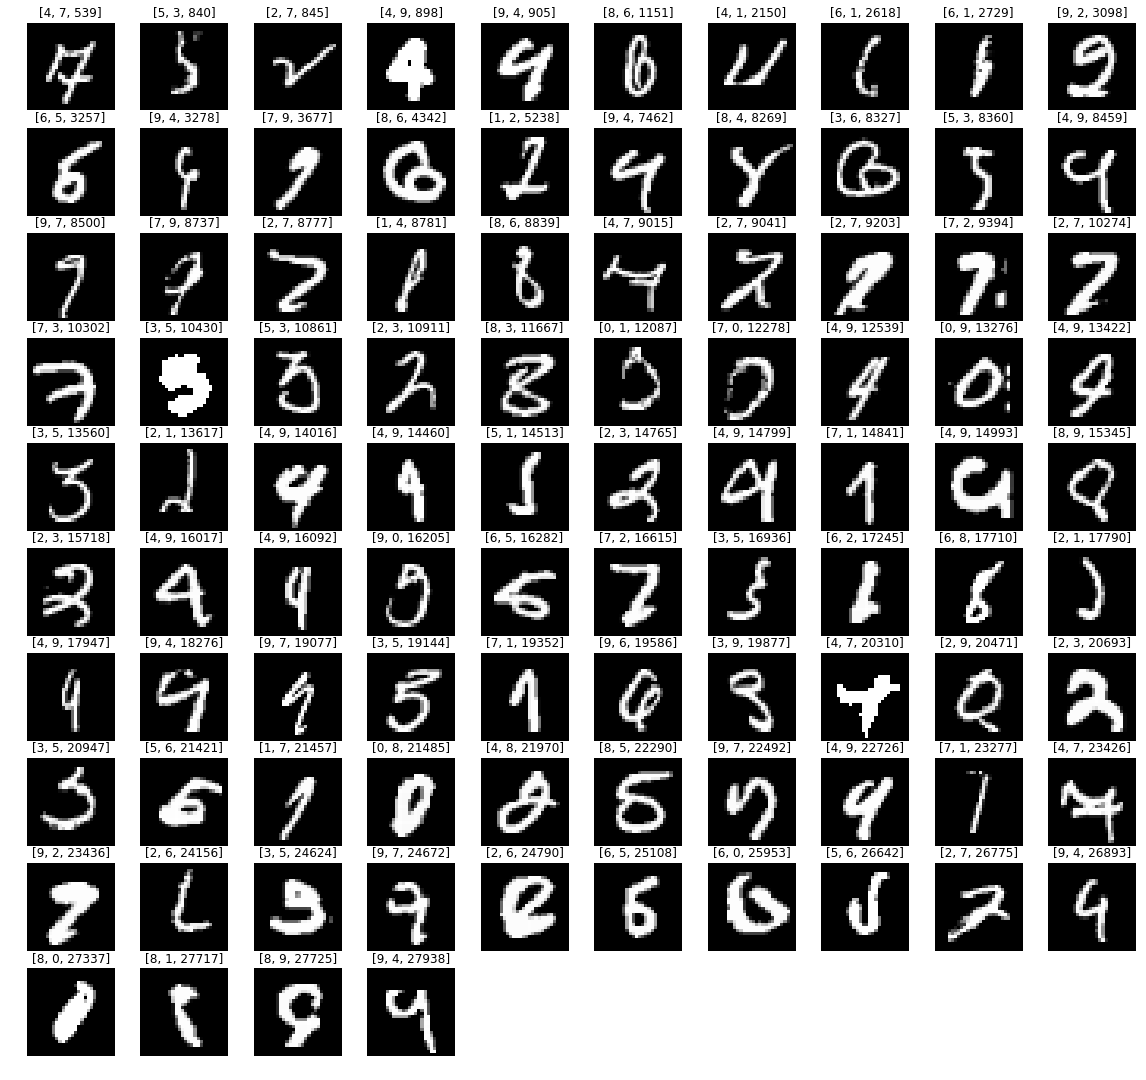

In [44]:
idx = prev_result[prev_result.Label.values != curr_result.Label.values].index
num=len(idx)
print('Difference:',num)
print('Image Title: [previous result, current result, id number]')

fig = plt.figure(figsize=(20, num//10*2+1))
for n in range(num):
    plt.subplot(num//10+1, 10, n+1)
    img = test[idx[n]-1].reshape(28,28)
    plt.imshow(img, cmap='gray')
    plt.title([prev_result.loc[idx[n]].Label, curr_result.loc[idx[n]].Label, idx[n]])
    plt.axis('off')
plt.show()